https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb

In [1]:
import os
import cv2
import random
import numpy as np 
import pandas as pd 
import seaborn as sns

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
mlp.rc('axes', labelsize=14)
mlp.rc('xtick', labelsize=12)
mlp.rc('ytick', labelsize=12)

# Tutorial 4: Clustering 

## K-Means
Let's start by generating some blobs:



In [2]:
from sklearn.datasets import make_blobs

In [3]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
train_img = [] #contains the images used for training the model
train_labels = [] #label of each image in x_train 
PATH = 'archive/Training'

for label in labels:
    img_dir = os.path.join(PATH, label)
    for img_file in os.listdir(img_dir):
        img = cv2.imread(f'{img_dir}/{img_file}')
        train_img.append(img)
        train_labels.append(label)
        
new_size = (255, 255)

for i in range(len(train_img)):
    img = train_img[i] 
    train_img[i] = cv2.resize(img, new_size)
    train_img[i] = cv2.cvtColor(train_img[i], cv2.COLOR_RGB2GRAY)/255

train_img = np.stack(train_img)
train_labels = np.stack(train_labels)

print("train_img shape : ", train_img.shape)
print("train_labels shape : ", train_labels.shape)

class_map = {
    'no_tumor': 0,
    'glioma_tumor': 1,
    'pituitary_tumor': 2,
    'meningioma_tumor': 3
}

train_labels = np.array([class_map[label] for label in train_labels])

train_img shape :  (2870, 255, 255)
train_labels shape :  (2870,)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_img.reshape((train_img.shape[0], 255*255)), train_labels, test_size = 0.3, random_state = 42)

In [5]:
from sklearn.preprocessing import StandardScaler #the Standard Scaler : X2 = (X1 - E(X1))/sqrt(Var(X1))
from sklearn.decomposition import PCA


S = StandardScaler()
X_train = S.fit_transform(X_train)
X_test = S.transform(X_test)

In [6]:
pca = PCA(n_components = 402)
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

X = pca_train[:,:2]

Now let's plot them:

In [7]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

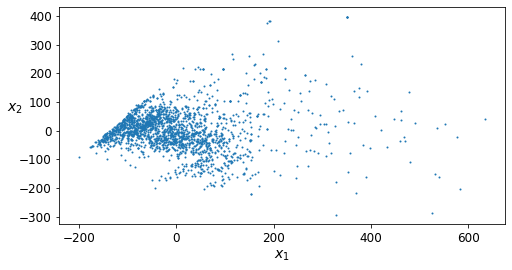

In [8]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

## Fit and Predict
Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

`fit_predict` Compute cluster centers and predict cluster index for each sample.



`kmeans.fit_predict` <- Important to learn <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit_predict">Documentation Link</a>

In [9]:
from sklearn.cluster import KMeans

In [10]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
y_pred

Each instance was assigned to one of the five clusters. In the context of clustering, an instance’s label is the **index of the cluster** that this instance gets assigned to by the algorithm: this is not to be confused with the **class labels** in classification

In [ ]:
y_pred is kmeans.labels_

And the following 5 _centroids_ (i.e., cluster centers) were estimated:

In [ ]:
kmeans.cluster_centers_

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to:

In [ ]:
kmeans.labels_

In [ ]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

## Decision Boundaries

Let's plot the model's decision boundaries. This gives us a Voronoi diagram:

In [ ]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    print(mins.shape, maxs.shape)
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    print(xx.shape, yy.shape)
    print(np.c_[xx.ravel(), yy.ravel()].shape)
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [ ]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

## Hard Clustering vs Soft Clustering
Instead of assigning each instance to a single cluster, which is called hard clustering, it can be useful to give each instance a score per cluster, which is called soft clustering. 

`kmeans.transform` Transforms X to a cluster-distance space.

`kmeans.transform` <- Important to learn <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.transform">Documentation Link</a>

In [ ]:
kmeans.transform(X_new)

In [ ]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

### K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. These hyperparameters will be explained below.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [ ]:
kmeans_iter1 = KMeans(n_clusters=4, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=4, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=4, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

And let's plot this:

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

### K-Means Variability

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

In [ ]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

In [ ]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=44)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=64)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")
plt.show()

### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_ metric:

In [ ]:
kmeans.inertia_

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [ ]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "_great is better_" rule.

In [ ]:
kmeans.score(X)

### Multiple Initializations|

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia. For example, here are the inertias of the two "bad" models shown in the previous figure:

In [ ]:
kmeans_rnd_init1.inertia_

In [ ]:
kmeans_rnd_init2.inertia_

As you can see, they have a higher inertia than the first "good" model we trained, which means they are probably worse.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [ ]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

In [ ]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### Finding the optimal number of clusters

What if the number of clusters was set to a lower or greater value than 5

In [ ]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

Ouch, these two models don't look great. What about their inertias?

In [ ]:
kmeans_k3.inertia_

In [ ]:
kmeans_k8.inertia_

No, we cannot simply take the value of  𝑘  that minimizes the inertia, since it keeps getting lower as we increase  𝑘 . Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of  𝑘  and analyze the resulting curve:

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [ ]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

In [ ]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Finding the optimal number of clusters is an ongoing research problem, and you can find out more about this topic in the literature

### Limits of K-Means 
-  It is necessary to run the algorithm several times to avoid suboptimal solutions
-  The number of clusters should be specified
- K-Means does not behave very well when the clusters have varying sizes, different densities, or nonspherical shapes

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [ ]:
plot_clusters(X)

In [ ]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

In [ ]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)


plt.show()

Try to apply a probabilistic model like the Gaussian mixture model (GMM) to cluster the latest example. 

You can find out more information about how to do it on Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition by Aurélien Géron Chapter 9. Unsupervised Learning Techniques